In [302]:
from tinygrad import Tensor, TinyJit
from tinygrad.nn.optim import SGD
from tinygrad.nn.state import get_parameters
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [303]:
x = Tensor([[0,0],[0,1],[1,0],[1,1]])
y = Tensor([[0],[1],[1],[0]])
x.shape, y.shape
# ((4, 2), (4, 1))

((4, 2), (4, 1))

In [304]:
class XOR_Net:
    def __init__(self):
        self.W1 = Tensor.normal(2, 2, mean=0, std=1)
        self.b1 = Tensor.randn(2)
        self.W2 = Tensor.randn(2, 1)
        self.b2 = Tensor.randn(1)
    
    def __call__(self, x):
        x = x.linear(self.W1, self.b1).sigmoid()
        x = x.linear(self.W2, self.b2)
        return x
    
    def int_output(self, x):
        return [int(i[0]) for i in self(x).round().numpy().tolist()]

In [305]:
model = XOR_Net()
optim = SGD(get_parameters(model), lr=0.01, momentum=0.9)

In [306]:
def train(model, x, y, optim, steps, allow_jit=True):

  def train_step(x, y):
    out = model(x)
    loss = ((out - y) ** 2).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss.realize()

  if allow_jit: train_step = TinyJit(train_step)

  with Tensor.train():
    losses, accuracies = [], []
    for i in (t := trange(steps)):
      loss = train_step(x, y).numpy()
      losses.append(loss)
      t.set_description("loss %.2f" % loss)
  return losses

In [307]:
losses = train(model, x, y, optim, 7500)
#loss 0.00: 100%|██████████| 7500/7500 [00:06<00:00, 1194.23it/s]

loss 0.25: 100%|██████████| 7500/7500 [00:06<00:00, 1166.14it/s]


In [273]:
model.int_output(x)

[0, 1, 1, 0]

In [299]:
def meshgrid(x, y):
  grid_x = Tensor.cat(*[x[idx:idx+1].expand(y.shape).unsqueeze(0) for idx in range(x.shape[0])])
  grid_y = Tensor.cat(*[y.unsqueeze(0)]*x.shape[0])
  return Tensor.cat(grid_x.reshape(-1, 1), grid_y.reshape(-1, 1), dim=1)

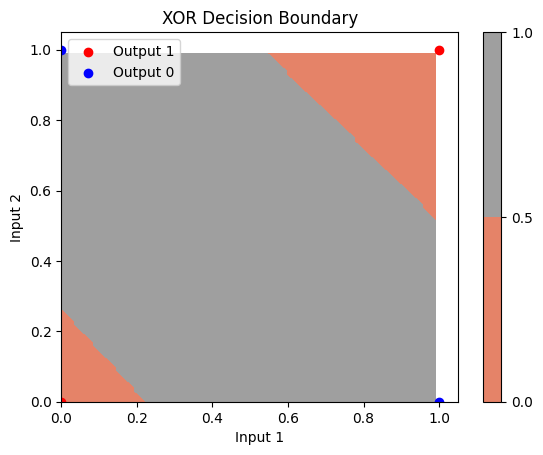

In [300]:
# Creating grid points in the input space
x_grid = Tensor.arange(0,1,.01)
y_grid = Tensor.arange(0,1,.01)
grid_points = meshgrid(x_grid, y_grid)

# Use the model to predict over the entire grid
predictions = model.int_output(grid_points)

# Convert the predictions to a numpy array and reshape for plotting
predictions_array = np.array(predictions).reshape(100, 100)

# Plotting
plt.contourf(x_grid.numpy(), y_grid.numpy(), predictions_array, levels=[0, 0.5, 1], cmap='RdGy')
plt.colorbar()
plt.scatter([0, 1], [0, 1], color='red', label='Output 1')
plt.scatter([0, 1], [1, 0], color='blue', label='Output 0')
plt.title('XOR Decision Boundary')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.legend()
plt.show()